In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
import os
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import cv2
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, models
import torchvision
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import random

In [2]:
# Папка с тестовыми фото
test_folder = 'C:/Users/Anastasia/Downloads/Test_photo'
# Папка с тренировочными изображениями
train_folder = 'C:/Users/Anastasia/Downloads/Categorized_Interior'

In [3]:
# Создание преобразований
transform = transforms.Compose([
    transforms.Resize(256),  # Пример изменения размера меньшей стороны до 256, сохраняя пропорции
    transforms.CenterCrop(224),  # Центральное обрезание изображений до размера 224x224
    transforms.ToTensor(),  # Преобразование изображения в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Пример нормализации изображений
])

In [4]:
# Выгружаю тренировочные данные
train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
# Выгружаю тестовый набор данных
test_data = datasets.ImageFolder(root=test_folder, transform=transform)

In [5]:
# Разделение данных на обучающий, валидационный и тестовый наборы
train_size = int(0.75 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_data, val_data = random_split(train_dataset, [train_size, val_size])


print(f'Training set size: {len(train_data)}')
print(f'Validation set size: {len(val_data)}')
print(f'Test set size: {len(test_data)}')

Training set size: 948
Validation set size: 317
Test set size: 60


In [6]:
# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [7]:
# Загрузка предварительно обученной модели ResNet-18
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Заморозка параметров предобученной модели
for param in model.parameters():
    param.requires_grad = False

# Определение количества классов
num_classes = len(train_dataset.classes)  # Количество уникальных классов

# Замена последнего слоя классификатора на новый линейный слой с нужным количеством классов
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [8]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Выбор устройства и числа эпох
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# Создаем листы, в которых будем хранить метрики трейна и валидации
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Обучение модели 
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Считаем accuracy на трейне
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss}, Training Accuracy: {train_accuracy}")

    # Валидация
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Epoch 1/25, Loss: 1.649545462926229, Training Accuracy: 0.33016877637130804
Validation Loss: 1.3315901637077332, Validation Accuracy: 0.5425867507886435
Epoch 2/25, Loss: 1.1546501596768697, Training Accuracy: 0.6497890295358649
Validation Loss: 1.0158378303050994, Validation Accuracy: 0.7381703470031545
Epoch 3/25, Loss: 0.9163421988487244, Training Accuracy: 0.7563291139240507
Validation Loss: 0.8384669840335846, Validation Accuracy: 0.807570977917981
Epoch 4/25, Loss: 0.7750575800736745, Training Accuracy: 0.7943037974683544
Validation Loss: 0.7437390506267547, Validation Accuracy: 0.8201892744479495
Epoch 5/25, Loss: 0.6923542579015096, Training Accuracy: 0.8227848101265823
Validation Loss: 0.7148554623126984, Validation Accuracy: 0.7949526813880127
Epoch 6/25, Loss: 0.621719558040301, Training Accuracy: 0.830168776371308
Validation Loss: 0.645758518576622, Validation Accuracy: 0.8359621451104101
Epoch 7/25, Loss: 0.5773731052875519, Training Accuracy: 0.8375527426160337
Validation

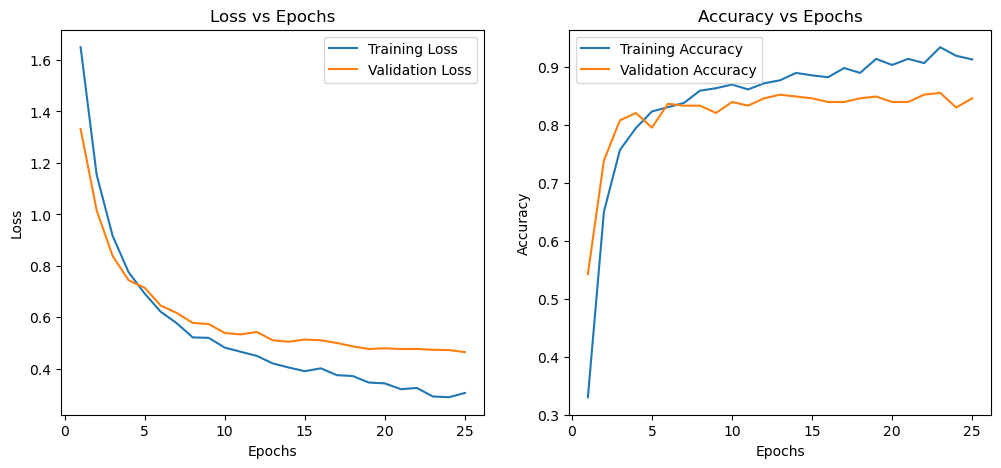

In [10]:
# Рисуем метрики
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Рисуем лосс
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Рисуем accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.show()

In [11]:
train_dataset.classes

['Boho', 'Farmhouse', 'Industrial', 'Minimalism', 'Modern', 'Traditional']

In [12]:
# Функция для денормализации изображений
def denormalize(tensor, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    tensor = tensor.numpy().transpose((1, 2, 0))
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    return tensor

In [13]:
# Применение модели к тестовым данным
model.eval()
predictions = []
test_images = []
confidences = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        predictions.extend(predicted.numpy())
        test_images.extend(images.numpy())
        confidences.extend(confidence.numpy())
        true_labels.extend(labels.numpy())


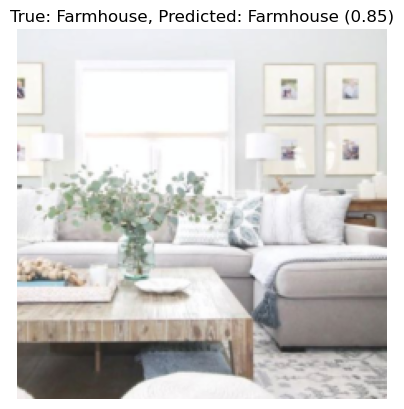

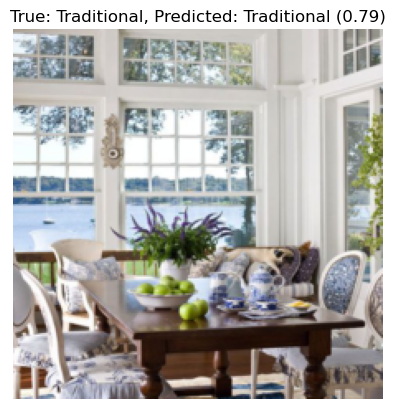

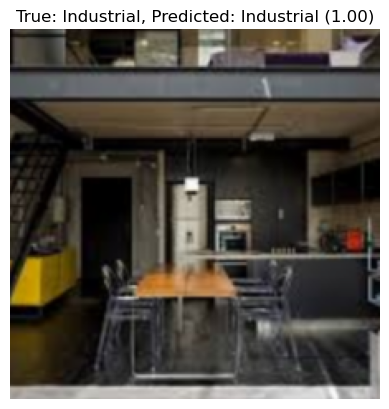

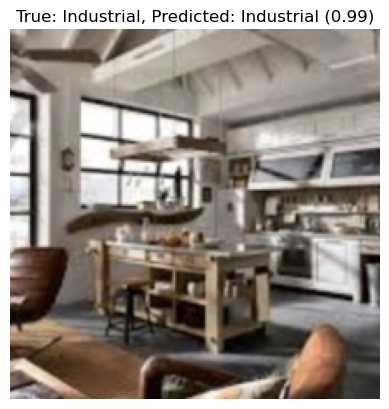

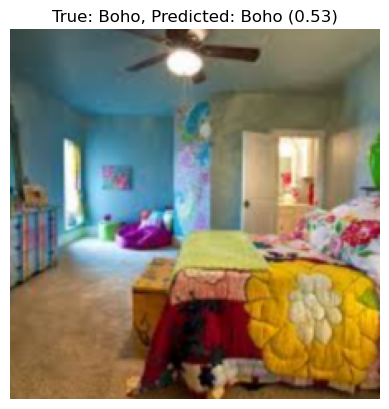

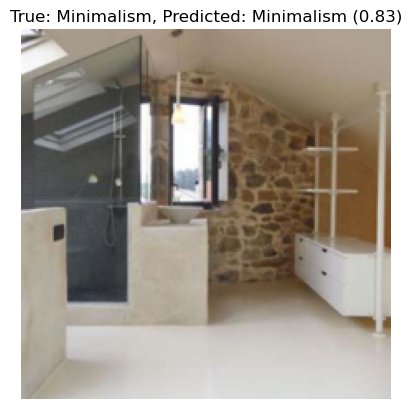

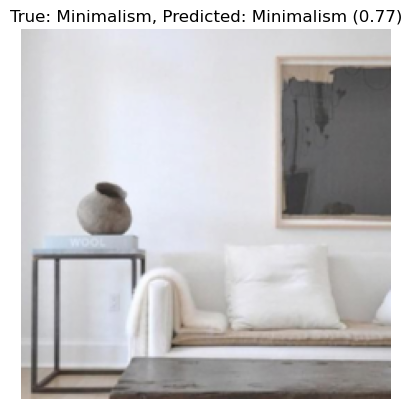

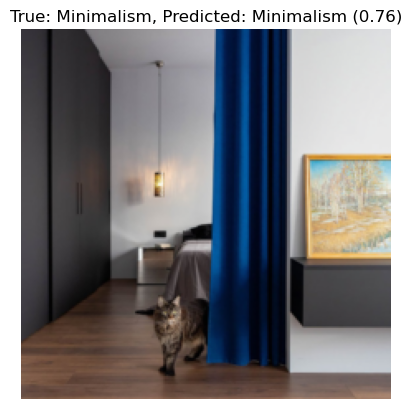

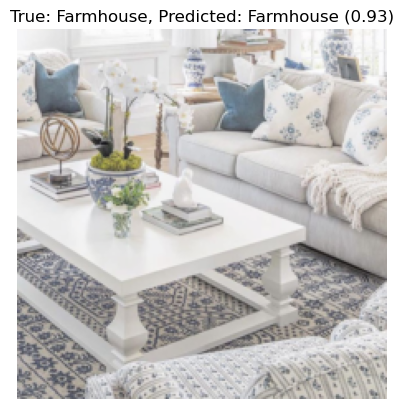

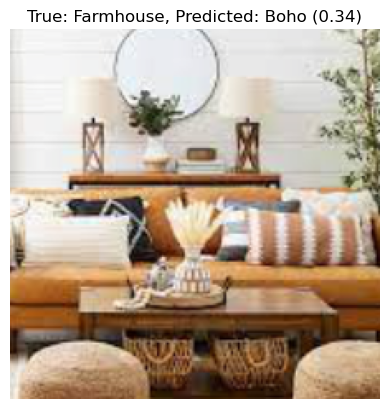

In [14]:
# Имя классов из набора данных
class_names = train_dataset.classes

# Отображение изображений с предсказаниями
def imshow(img, title):
    img = denormalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Выводим случайные 10 изображений с их предсказаниями и уверенностью
random_indices = random.sample(range(len(test_images)), 10)
for i in random_indices:
    true_class = class_names[true_labels[i]]
    predicted_class = class_names[predictions[i]]
    confidence = confidences[i]
    title = f"True: {true_class}, Predicted: {predicted_class} ({confidence:.2f})"
    imshow(torch.tensor(test_images[i]), title)